In [1]:
### Import packages ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
### Load data ###
users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1", parse_dates = [1,5])
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0


In [3]:
engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates = [0])
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
### Convert from UNIX to datetime ###
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit = 's')
users.rename(columns = {'object_id': 'user_id'}, inplace = True)
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [5]:
### Check dataframes ###
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [7]:
### Defining "adopted user" = logged in 3 separate days within 7 days ### 

visit_count = engagement.groupby('user_id').visited.count()
not_adopted = list(visit_count[visit_count < 3].index)
len(not_adopted)

6575

The above code creates a list of users that have logged in less than 3 times total. We can automatically weed those people out as they cannot have logged in at least 3 times in 7 days if their total login count is less than 3.

This list does not include any of the people that have not logged in AT ALL i.e. users with `users['last_session_creation_time'] == NaT`. These need to also be added into the `not_adopted` list.

In [8]:
### Create separate `not_logged` list and extend `not_adopted` list ###
not_logged = users[users['last_session_creation_time'].isnull()]['user_id']
not_adopted.extend(not_logged)
not_adopted = list(set(not_adopted))
len(not_adopted)

9752

In [9]:
### Define function to determine whether a user is adopted user or not ###

def adopted(user_id):
    if user_id not in not_adopted:
        activity = engagement[engagement['user_id'] == user_id]
        for time in activity.time_stamp:
            datemax = time + datetime.timedelta(days = 7)
            weekly_activity = activity[(activity['time_stamp'] > time) & (activity['time_stamp'] < datemax)]
            if len(weekly_activity) >= 3:
                return True
                break
            else:
                continue
    return False

In [10]:
users['adopted'] = users['user_id'].apply(adopted)

In [11]:
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False


In [12]:
users['adopted'].value_counts()

False    10703
True      1297
Name: adopted, dtype: int64

In [13]:
users['adopted'].value_counts(normalize = True)

False    0.891917
True     0.108083
Name: adopted, dtype: float64

Around ~10.8% of users registered are actually adopted users. Time to investigate how these two groups differ

In [20]:
users['invited_by_user_id'].value_counts()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
           ..
2746.0      1
10456.0     1
8371.0      1
6266.0      1
3572.0      1
Name: invited_by_user_id, Length: 2564, dtype: int64

In [19]:
groupby_df = users.groupby('adopted').agg(sum)[['opted_in_to_mailing_list', 'enabled_for_marketing_drip']]
groupby_df

,opted_in_to_mailing_list,enabled_for_marketing_drip
adopted,,
False,2655,1595
True,339,197


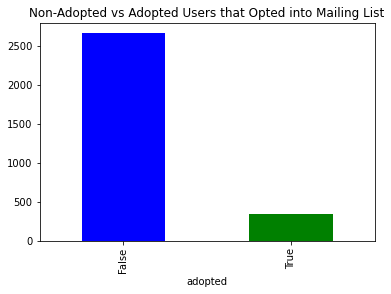

In [32]:
import seaborn as sns
groupby_df['opted_in_to_mailing_list'].plot(kind = 'bar', color = ('blue', 'green'))
plt.title('Non-Adopted vs Adopted Users that Opted into Mailing List')
plt.show()

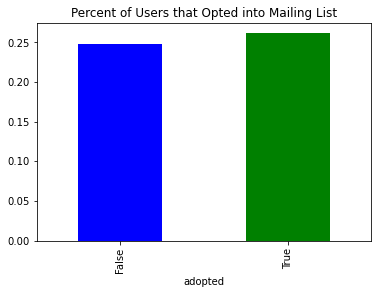

In [35]:
mailinglist_ratio = groupby_df['opted_in_to_mailing_list']/users['adopted'].value_counts()
mailinglist_ratio.plot(kind = 'bar', color = ('blue', 'green'))
plt.title('Percent of Users that Opted into Mailing List')
plt.show()

In [48]:
mailinglist_ratio

adopted
False    0.248061
True     0.261372
dtype: float64

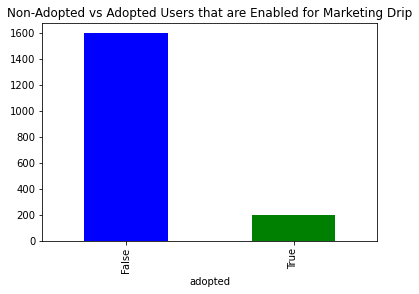

In [36]:
groupby_df['enabled_for_marketing_drip'].plot(kind = 'bar', color = ('blue', 'green'))
plt.title('Non-Adopted vs Adopted Users that are Enabled for Marketing Drip')
plt.show()

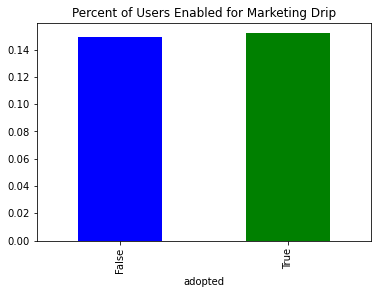

In [38]:
marketing_ratio = groupby_df['enabled_for_marketing_drip']/users['adopted'].value_counts()
marketing_ratio.plot(kind = 'bar', color = ('blue', 'green'))
plt.title('Percent of Users Enabled for Marketing Drip')
plt.show()

In [49]:
marketing_ratio

adopted
False    0.149024
True     0.151889
dtype: float64

In [42]:
mailing_and_marketing = users[(users['opted_in_to_mailing_list'] == 1) & (users['enabled_for_marketing_drip'] == 1)]

In [46]:
mailing_and_marketing.adopted.value_counts(normalize = True)

False    0.888972
True     0.111028
Name: adopted, dtype: float64

From a quick glance at the dataset, I assumed users that opted into the mailing list and are enabled for marketing drip would more likely be adopted users, as it could mean these users are more likely to use the service. However, this was not the case. Around 26% and 15% of adopted users opted into the mailing list and are enabled for marketing drip, respectively. This is not significantly different enough from the ratio for non-adopted users: 24.8% and 14.9% for mailing list and marketing drip, respectively. I then investigated if users that opted into the mailing list AND are enabled for marketing drip are more likely to be adopted users. This was not necessarily the case. Only 11% of people that are in both categories are adopted users. This is almost the same perentage of adopted users as a whole. With more time, I would further investigate how many days have passed since the account creation time and the next login time. Excluding users that have never logged in after creation, I think this feature would provide a more interesting detail on how adopted users can be predicted. 